# Word2Vec Model

Write a program that trains Word2Vec model. Do not use print() instructions in your code, otherwise test procedure will not succeed; the message "Wrong Answer" indicates answer format is incorrect (print() in the code, missing words in the dictionary, etc.). The message "Embeddings are not good enough" means you're on the right track and you should focus on the model improvement.  
  
You may think of the input string as being pre-processed with the following function:

```python
import re
import string

def clean(inp: str) -> str:
    inp = inp.translate(str.maketrans(string.punctuation, " "*len(string.punctuation)))
    inp = re.sub(r'\s+', ' ', inp.lower())
    return inp
```

I.e. given the input "Your string!" the output will be "your string ".


Input: data (string) - cleaned documents without punctuation in one line  
Output: w2v_dict (dict: key (string) - a word from vocabulary, value (numpy array) - the word's embedding)

Time limit: 25 seconds  
Memory limit: 128 MB

You may use only `numpy` and `pytorch` libraries

In [34]:
import re
import string

import numpy as np
import torch
import torch.nn.functional as F
from tqdm.notebook import trange
import matplotlib.pyplot as plt

## Pipeline

### Split string into words

In [35]:
def clean(inp: str) -> str:
    # Replace punctuation with spaces
    inp = inp.translate(
        str.maketrans(string.punctuation, " " * len(string.punctuation))
    )

    # Remove non-Russian characters and keep only Cyrillic letters (Russian range)
    inp = re.sub(r"[^а-яА-ЯёЁ]", " ", inp)

    # Replace multiple spaces with a single space and convert to lowercase
    inp = re.sub(r"\s+", " ", inp.lower())

    return inp.strip()

In [36]:
data = open("onegin.txt", "r").read()
words = clean(data).split()
words[:10]

['мой',
 'дядя',
 'самых',
 'честных',
 'правил',
 'когда',
 'не',
 'в',
 'шутку',
 'занемог']

In [37]:
len(words)

22443

In [38]:
words = words[:500]

### Create the vocabulary (wtoi, itow)

In [39]:
vocab = sorted(list(set(words)))
vocab_size = len(vocab)
vocab_size

358

In [40]:
wtoi = {w: i for i, w in enumerate(vocab)}
itow = {i: w for w, i in wtoi.items()}

In [41]:
ids = torch.tensor([wtoi[w] for w in words])

### Create and randomly initialize the embedding matrices (therefore we have 2 vector for 1 word)

In [43]:
emb_size = 25
emb_o = torch.randn((vocab_size, emb_size), requires_grad=True)
emb_c = torch.randn((vocab_size, emb_size), requires_grad=True)

### Training loop

In [54]:
window_size = 3
epochs = 100

In [47]:
opt = torch.optim.Adam([emb_o, emb_c], lr=3e-4)

In [48]:
loss_hist = []

In [55]:
for _ in trange(epochs):
    for pos_c, ix_c in enumerate(ids):
        # indices of context vectors
        ix_o = torch.tensor(
            [
                ids[pos_o]
                for pos_o in pos_c + np.arange(-window_size, window_size + 1)
                if pos_o != pos_c and 0 <= pos_o < len(ids)
            ]
        )
        
        # calc dot product b/w center vector and all vectors to get similarities
        sim = emb_o @ emb_c[ix_c]
        loss = F.cross_entropy(sim.repeat(len(ix_o), 1), ix_o)
        
        opt.zero_grad()
        loss.backward()
        opt.step()
    
    # track loss
    with torch.no_grad():
        sim = emb_c[ids] @ emb_o.T
        loss = F.cross_entropy(sim, ids).item()
        loss_hist.append(loss)

  0%|          | 0/100 [00:00<?, ?it/s]

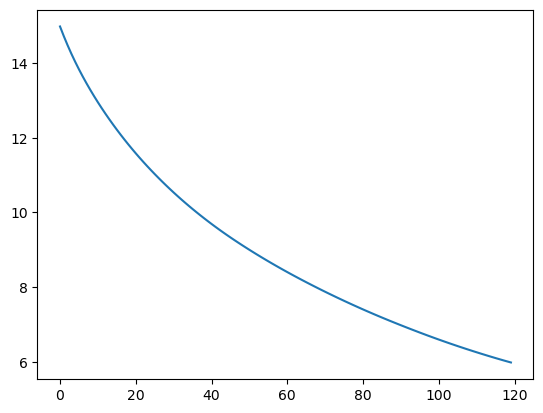

In [56]:
plt.plot(loss_hist)

### Construct the output dict

In [57]:
# averages the emb matrices
emb_avg = np.array((emb_c.data + emb_o.data) / 2)

In [58]:
wtoemb = {}
for w in vocab:
    wtoemb[w] = emb_avg[wtoi[w]]